# A Thaliana dataset: Finding the best cd-hit threshold

## Task

After the outliers were found and removed from the dataset, which improved classification performance, it is now time to find a good sequence clustering threshold for the dataset. Clustering is performed through a self-written python wrapper for cd-hit.

Sequence clustering is important for this task, because it reduces dependency between the test set and the training set, as well as reduncancy. 

The sequence identity threshold is defined by cd-hit as: "number of identical amino acids or bases in alignment divided by the full length of the shorter sequence".

The default threshold of cd-hit is 90%, some other publications have used a transporter dataset with 70% threshold. On the other hand, those other publications classified transporters independently of organism, so maybe 90% is more appropriate for looking at one organism at a time.

## Imports

In [1]:
import os
import sys

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from joblib import Parallel, delayed

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.under_sampling import RandomUnderSampler

sys.path.append("../src")
from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from models.eval import nested_crossval


## Creating the transporter dataset, without outliers

In [2]:
# "human": 		9606
# "athaliana":	3702
# "ecoli": 		83333
# "yeast": 		559292

N_THREADS = 16
LOG_FILE = f"../logs/athaliana_amino_sugar.log"

if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass

create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="remove",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose=True,
    tax_ids_filter=[3702],
    output_tsv="../data/datasets/athaliana_amino_sugar.tsv",
    output_fasta=f"../data/datasets/athaliana_amino_sugar.fasta",
    output_log=LOG_FILE,
)


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...
...,...,...,...,...,...,...,...,...
Q94EI9,Sugar transport,Membrane;Transmembrane,Transport,At3g14410 MLN21.19,Probable sugar phosphate/phosphate translocato...,NaN,3702,MADRSKGFMRAEFVTYAYILLYIALSSGQIFFNKWVLSSKEINFPY...
Q8L6Z8,Sugar transport,Membrane;Transmembrane,Transport,At3g03090 T17B22.22,D-xylose-proton symporter-like 1,2.A.1.1.45,3702,MGFDPENQSISSVGQVVGDSSSGGITAEKEPLLKENHSPENYSVLA...
Q9FDZ5,Sugar transport,Membrane;Transmembrane,Antiport;Transport,URGT6 At1g34020 F12G12.16 T15K4.8,UDP-rhamnose/UDP-galactose transporter 6 (UDP-...,NaN,3702,MAPVSKADKKAAVDAAAWMFNVVTSVGIIIVNKALMATYGYSFATT...


## Creating AAC features for all thresholds

In [3]:
for identity_threshold in range(40, 101, 10):
    cd_hit(
        executable_location="cd-hit",
        input_fasta=f"../data/datasets/athaliana_amino_sugar.fasta",
        output_fasta=f"../data/datasets/athaliana_amino_sugar_cluster{identity_threshold}.fasta",
        log_file=LOG_FILE,
        identity_threshold=identity_threshold,
        n_threads=N_THREADS,
        memory=4096,
        verbose=True,
    )

for composition_type in ["aac", "paac"]:
    for identity_threshold in range(40, 101, 10):
        fasta_to_labels(
            input_fasta=f"../data/datasets/athaliana_amino_sugar_cluster{identity_threshold}.fasta",
            output_tsv=f"../data/features/athaliana_amino_sugar_cluster{identity_threshold}_labels.tsv",
        )
        calculate_composition_feature(
            input_fasta=f"../data/datasets/athaliana_amino_sugar_cluster{identity_threshold}.fasta",
            output_tsv=f"../data/features/athaliana_amino_sugar_cluster{identity_threshold}_{composition_type}.tsv",
            feature_type=composition_type,
        )


## What is a reasonable number of samples?

Answer: More than 80.

{'Sugar transport': 1, 'Amino-acid transport': 0}


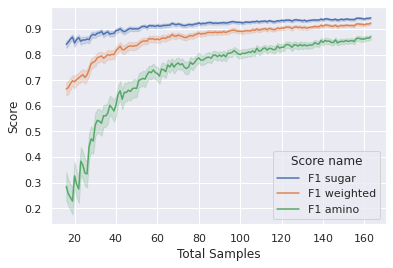

In [4]:
def test_case(df_features, df_labels, n_samples, random_seed, score):
    df_features_sampled, _, df_labels_sampled, _ = train_test_split(
        df_features,
        df_labels,
        stratify=df_labels,
        random_state=random_seed,
        train_size=n_samples,
        shuffle=True,
    )

    X = df_features_sampled.to_numpy()
    y = label_encoder.transform(df_labels_sampled.labels)

    estimator = make_pipeline(
        StandardScaler(), SVC(class_weight="balanced")
    )

    cv_results = cross_val_score(estimator, X, y, n_jobs=1, scoring=score[1])
    records = []
    for cv_result in cv_results:
        records.append([score[0], n_samples, cv_result])
    return records


df_aac_100 = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster100_aac.tsv", index_col=0
)
df_labels_100 = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster100_labels.tsv", index_col=0
)
label_encoder = LabelEncoder()
label_encoder.fit(df_labels_100.labels)

print(
    {
        label: enc
        for label, enc in zip(
            df_labels_100.labels.unique(),
            label_encoder.transform(df_labels_100.labels.unique()),
        )
    }
)
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

records_list = Parallel(n_jobs=-1)(
    delayed(test_case)(df_aac_100, df_labels_100, n_samples, random_seed, score)
    for n_samples in range(16, df_aac_100.shape[0] - 1)
    for random_seed in range(50)
    for score in [
        ("F1 sugar", make_scorer(f1_score, pos_label=1)),
        ("F1 weighted", make_scorer(f1_score, average="weighted")),
        ("F1 amino", make_scorer(f1_score, pos_label=0)),
    ]
)
records = []
for sl in records_list:
    for ssl in sl:
        records.append(ssl)
results_df = pd.DataFrame.from_records(
    records,
    columns=["Score name", "Total Samples", "Score"],
)
sns.set_theme()
# sns.set(font_scale=2)
g = sns.lineplot(
    data=results_df,
    x="Total Samples",
    y="Score",
    hue="Score name",
)
plt.savefig(
    "plots/athaliana_sugar_amino_cluster100_aac_f1_minsamples_stratified.png", dpi=300
)


## Only subsampling sugar

{'Sugar transport': 1, 'Amino-acid transport': 0}


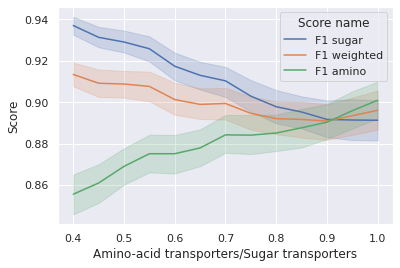

In [5]:
sns.set_theme()


def test_case(df_features, df_labels, freq_samples, random_seed, score):
    # df_features_sampled, _, df_labels_sampled, _ = train_test_split(
    #     df_features,
    #     df_labels,
    #     stratify=df_labels,
    #     random_state=random_seed,
    #     train_size=n_samples,
    #     shuffle=True,
    # )
    rus = RandomUnderSampler(random_state=random_seed, sampling_strategy=freq_samples)
    df_features_sampled, df_labels_sampled = rus.fit_resample(df_features, df_labels)

    print(df_labels_sampled.value_counts())

    X = df_features_sampled.to_numpy()
    y = label_encoder.transform(df_labels_sampled.labels)

    estimator = make_pipeline(StandardScaler(), SVC(class_weight="balanced"))

    cv_results = cross_val_score(estimator, X, y, n_jobs=1, scoring=score[1])
    records = []
    for cv_result in cv_results:
        records.append([score[0], freq_samples, cv_result])
    return records


df_aac_100 = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster100_aac.tsv", index_col=0
)
df_labels_100 = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster100_labels.tsv", index_col=0
)
label_encoder = LabelEncoder()
label_encoder.fit(df_labels_100.labels)

print(
    {
        label: enc
        for label, enc in zip(
            df_labels_100.labels.unique(),
            label_encoder.transform(df_labels_100.labels.unique()),
        )
    }
)
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

records_list = Parallel(n_jobs=-1)(
    delayed(test_case)(df_aac_100, df_labels_100, freq_samples, random_seed, score)
    for freq_samples in [
        0.4,
        0.45,
        0.5,
        0.55,
        0.6,
        0.65,
        0.7,
        0.75,
        0.8,
        0.85,
        0.9,
        0.95,
        1.0,
    ]
    for random_seed in range(50)
    for score in [
        ("F1 sugar", make_scorer(f1_score, pos_label=1)),
        ("F1 weighted", make_scorer(f1_score, average="weighted")),
        ("F1 amino", make_scorer(f1_score, pos_label=0)),
    ]
)
records = []
for sl in records_list:
    for ssl in sl:
        records.append(ssl)
results_df = pd.DataFrame.from_records(
    records,
    columns=["Score name", "Amino-acid transporters/Sugar transporters", "Score"],
)
sns.set_theme()
# sns.set(font_scale=2)
g = sns.lineplot(
    data=results_df,
    x="Amino-acid transporters/Sugar transporters",
    y="Score",
    hue="Score name",
)

plt.savefig("plots/athaliana_sugar_amino_cluster100_aac_downsampling.png", dpi=300)


## Plots

### Substrate count

Sklearn reccomends 50 samples, my test have shown that models don't work reliably below 25 samples. 

A cluster threshold of at least 70% would be a good idea. 

A higher threshold would be better if:

- The overfitting and standard deviation is reduced
- The mean does not change too much, as that could indicate information sharing between training and test set.

keyword             Amino-acid transport  Sugar transport  Ratio
identity threshold                                              
40                                    16               36   0.44
50                                    23               55   0.42
60                                    27               76   0.36
70                                    33               84   0.39
80                                    41               94   0.44
90                                    46              110   0.42
100                                   47              118   0.40


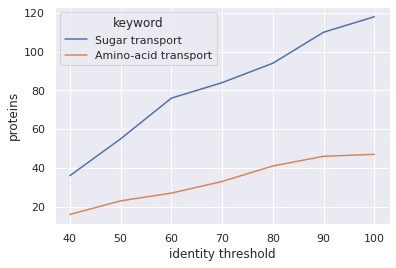

In [6]:
substrate_value_counts = []
for identity_threshold in range(40, 101, 10):
    df_vc = pd.read_table(
        f"../data/features/athaliana_amino_sugar_cluster{identity_threshold}_labels.tsv",
        index_col=0,
    ).value_counts()
    for substrate_kw in ["Sugar transport", "Amino-acid transport"]:
        substrate_value_counts.append(
            [identity_threshold, substrate_kw, df_vc[substrate_kw]]
        )
substrate_value_counts = pd.DataFrame.from_records(
    data=substrate_value_counts, columns=["identity threshold", "keyword", "proteins"]
)
sns.lineplot(
    data=substrate_value_counts, x="identity threshold", y="proteins", hue="keyword"
)
plt.savefig("plots/athaliana_sugar_amino_clustering_samples.png", dpi=300)
results = substrate_value_counts.pivot(
    index="identity threshold", columns="keyword", values="proteins"
)
results["Ratio"] = results["Amino-acid transport"] / results["Sugar transport"]
print(results.round(2))

#### Is the 100% clustering dataset the same as the dataset without clustering?

- Happens when there are sequences that are 100% identical to each other.
- No, clustering at 100% does not change the original dataset.

In [7]:
fasta_to_labels(
    input_fasta=f"../data/datasets/athaliana_amino_sugar.fasta",
    output_tsv=f"../data/features/athaliana_amino_sugar_labels.tsv",
)
print(
    pd.read_table(
        f"../data/features/athaliana_amino_sugar_labels.tsv",
        index_col=0,
    ).value_counts()
)
print(
    pd.read_table(
        f"../data/features/athaliana_amino_sugar_cluster100_labels.tsv",
        index_col=0,
    ).value_counts()
)


labels              
Sugar transport         118
Amino-acid transport     47
dtype: int64
labels              
Sugar transport         118
Amino-acid transport     47
dtype: int64


### Pairwise correlation: Samples

As expected, pairwise correlation scores across the dataset increase as more similar samples are added.

There seem to be a small number of proteins that have lower correlations to the rest of the dataset as the remaining proteins.

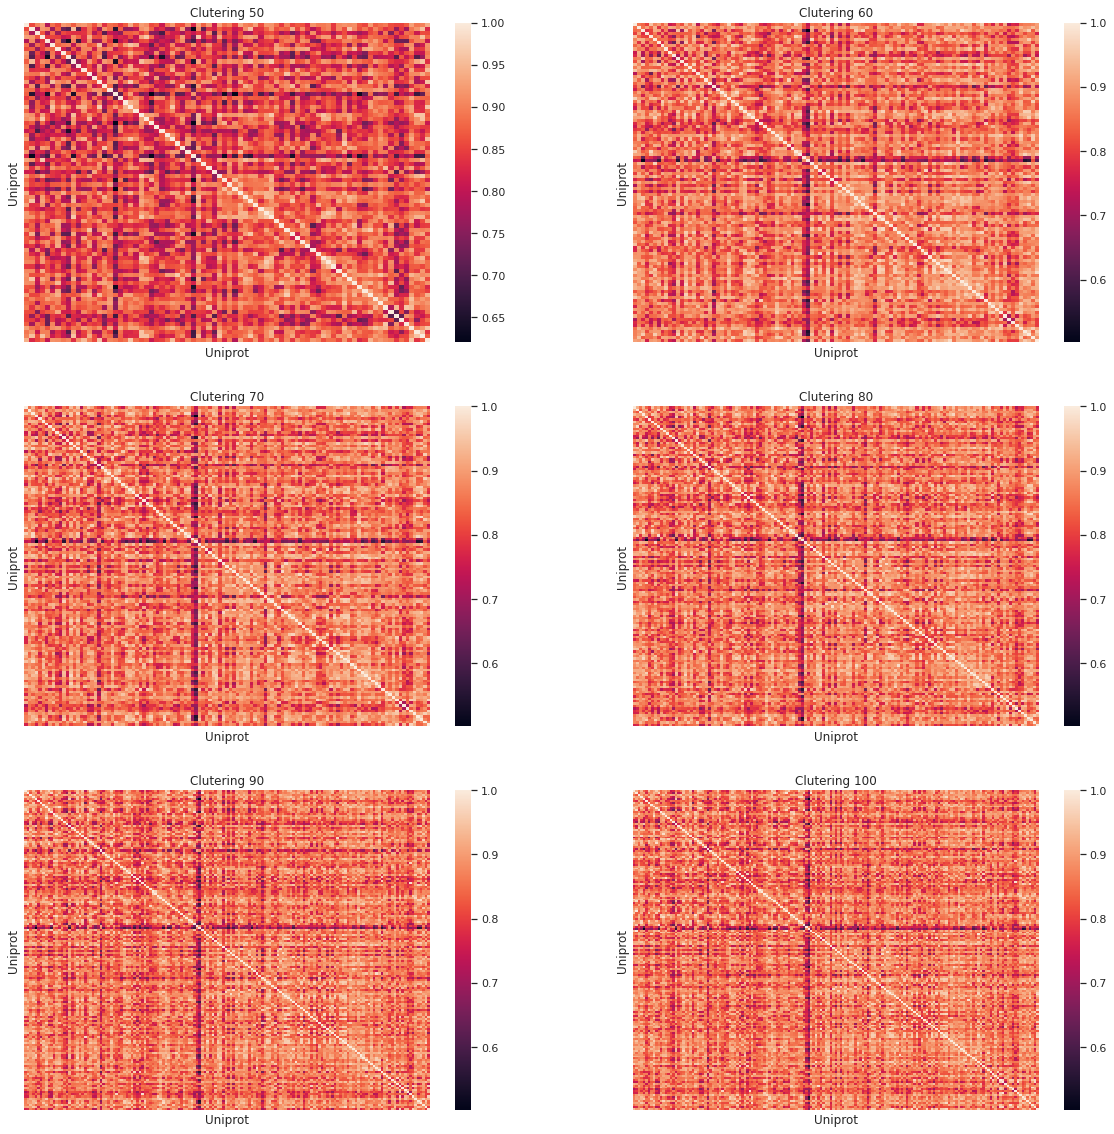

In [8]:
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (20, 20)})
fig, axes = plt.subplots(3, 2)
for thresh, pos in zip(
    [50, 60, 70, 80, 90, 100], [[i, j] for i in range(3) for j in range(2)]
):
    df_aac = pd.read_table(
        f"../data/features/athaliana_amino_sugar_cluster{thresh}_aac.tsv", index_col=0
    )
    df_labels = pd.read_table(
        f"../data/features/athaliana_amino_sugar_cluster{thresh}_labels.tsv",
        index_col=0,
    )

    g = sns.heatmap(
        df_aac.transpose().corr(),
        xticklabels=[],
        yticklabels=[],
        ax=axes[pos[0], pos[1]],
    )
    g.set_title(f"Clutering {thresh}")


#### What are the lines on the pairwise sample correlation heatmaps?

It appears that there is another small cluster of proteins that differ from the rest of the dataset. 

The protein with the lowest average correlation to the rest of the dataset was Glutamine Dumper 6, which I forgot to include in the outliers. I added GDU6 to the outliers at the top of this notebook and ran it again, the same for the first notebook.

The remaining proteins with relatively low correlation (pearson of 0.7 to 0.8) belong to the SWEET family of sugar transporters. They are bidirectional sugar transporters, belonging to superfamily 2.A. This does not look too concerning, I think I will leave them in for now.

In [9]:
df_aac = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster70_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/athaliana_amino_sugar_cluster70_labels.tsv", index_col=0
)

mean_corr = df_aac.transpose().corr().mean()
mean_corr = pd.DataFrame(
    mean_corr[mean_corr < 0.8].sort_values(), columns=["mean_correlation"]
)

df_annotations = pd.read_table(
    "../data/datasets/athaliana_amino_sugar.tsv",
    index_col=0,
    usecols=["Uniprot", "keywords_transport", "gene_names", "protein_names", "tcdb_id"],
)

mean_corr.join(df_annotations, how="left")


,mean_correlation,keywords_transport,gene_names,protein_names,tcdb_id
Uniprot,,,,,
Q9FM10,0.697744,Sugar transport,SWEET5 VEX1 At5g62850 MQB2.17,Bidirectional sugar transporter SWEET5 (AtSWEE...,NaN
Q8LFH5,0.767918,Sugar transport,SWEET8 RPG1 At5g40260 MSN9.17 MSN9_160,Bidirectional sugar transporter SWEET8 (AtSWEE...,2.A.123.1.5
Q9LUE3,0.769441,Sugar transport,SWEET10 At5g50790 MFB16.19,Bidirectional sugar transporter SWEET10 (AtSWE...,NaN
Q42400,0.781085,Amino-acid transport,AAP1 NAT2 At1g58360 F19C14.3 ZCF54,Amino acid permease 1 (Amino acid transporter ...,2.A.18.2.1
Q9FY94,0.790886,Sugar transport,SWEET15 SAG29 At5g13170 T19L5.130,Bidirectional sugar transporter SWEET15 (AtSWE...,2.A.123.1.3
Q94B38,0.798467,Sugar transport,GPT2 At1g61800 F8K4.1,"Glucose-6-phosphate/phosphate translocator 2, ...",2.A.7.9.6


### Pairwise correlation of features

- The additional samples don't seem to have a significant impact on feature correlations, they look very similar.

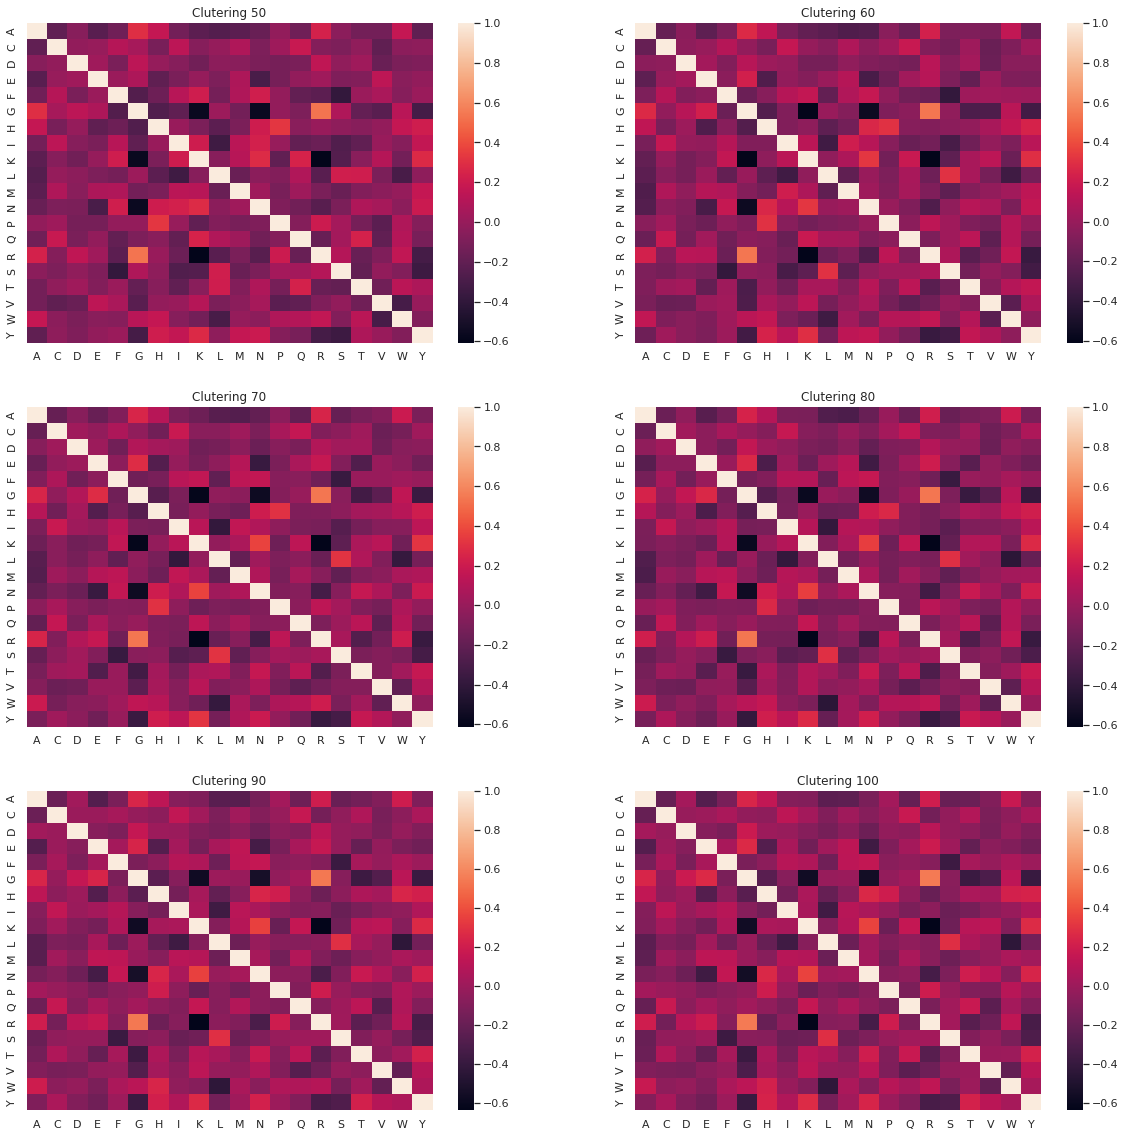

In [10]:
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (20, 20)})
fig, axes = plt.subplots(3, 2)
for thresh, pos in zip(
    [50, 60, 70, 80, 90, 100], [[i, j] for i in range(3) for j in range(2)]
):
    df_aac = pd.read_table(
        f"../data/features/athaliana_amino_sugar_cluster{thresh}_aac.tsv", index_col=0
    )
    df_labels = pd.read_table(
        f"../data/features/athaliana_amino_sugar_cluster{thresh}_labels.tsv",
        index_col=0,
    )

    g = sns.heatmap(df_aac.corr(), ax=axes[pos[0], pos[1]])
    g.set_title(f"Clutering {thresh}")


## Code for creating the classification plot

In [11]:
sns.set(rc={"figure.figsize": (10, 8)})


def classifier_clustering_plot(
    dataset_name: str,
    feature_name: str,
    pipe: Pipeline,
    clustering_thresholds=list(range(40, 101, 10)),
    params={},
    scoring="f1_weighted",
    title="",
    cv_splits=5,
    ax=None,
):
    test_results_long = []
    for clustering_threshold in clustering_thresholds:
        X = pd.read_table(
            f"../data/features/{dataset_name}_cluster{clustering_threshold}_{feature_name}.tsv",
            index_col=0,
        ).to_numpy()
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(
            pd.read_table(
                f"../data/features/{dataset_name}_cluster{clustering_threshold}_labels.tsv",
                index_col=0,
            )
            .to_numpy()
            .ravel()
        )

        results = nested_crossval(
            X=X.copy(),
            y=y.copy(),
            params=params,
            pipe=pipe,
            scoring=scoring,
            cv_splits=cv_splits,
        )
        for cv_iteration in range(cv_splits):
            for test_train_label in ["test_score", "train_score"]:
                test_results_long.append(
                    [
                        clustering_threshold,
                        test_train_label,
                        results.loc[test_train_label, cv_iteration],
                    ]
                )
    test_results_long = pd.DataFrame.from_records(
        test_results_long, columns=["clustering_threshold", "dataset", scoring.upper()]
    )
    g = sns.lineplot(
        data=test_results_long,
        x="clustering_threshold",
        y=scoring.upper(),
        hue="dataset",
        ax=ax,
    )
    g.set_ylim(0, 1.01)
    g.set_xticks(clustering_thresholds)
    g.set_title(title)
    return g


## Training classifiers on dataset with different clustering thresholds

- Without PCA, Feature selection or Parameter tuning.
- Only AAC to keep it simple. PAAC and PSSM scores should be better than AAC, COEXP needs its own Notebook
- Results: 90% clustering leads to less overfitting and variance, slightly better or equal mean scores.
- Conclusion:
    - Higher cluster threshold = better model
    - Is 90% clustering threshold the best?

<AxesSubplot:title={'center':'KNN trained on AAC (no PCA)'}, xlabel='clustering_threshold', ylabel='F1_WEIGHTED'>

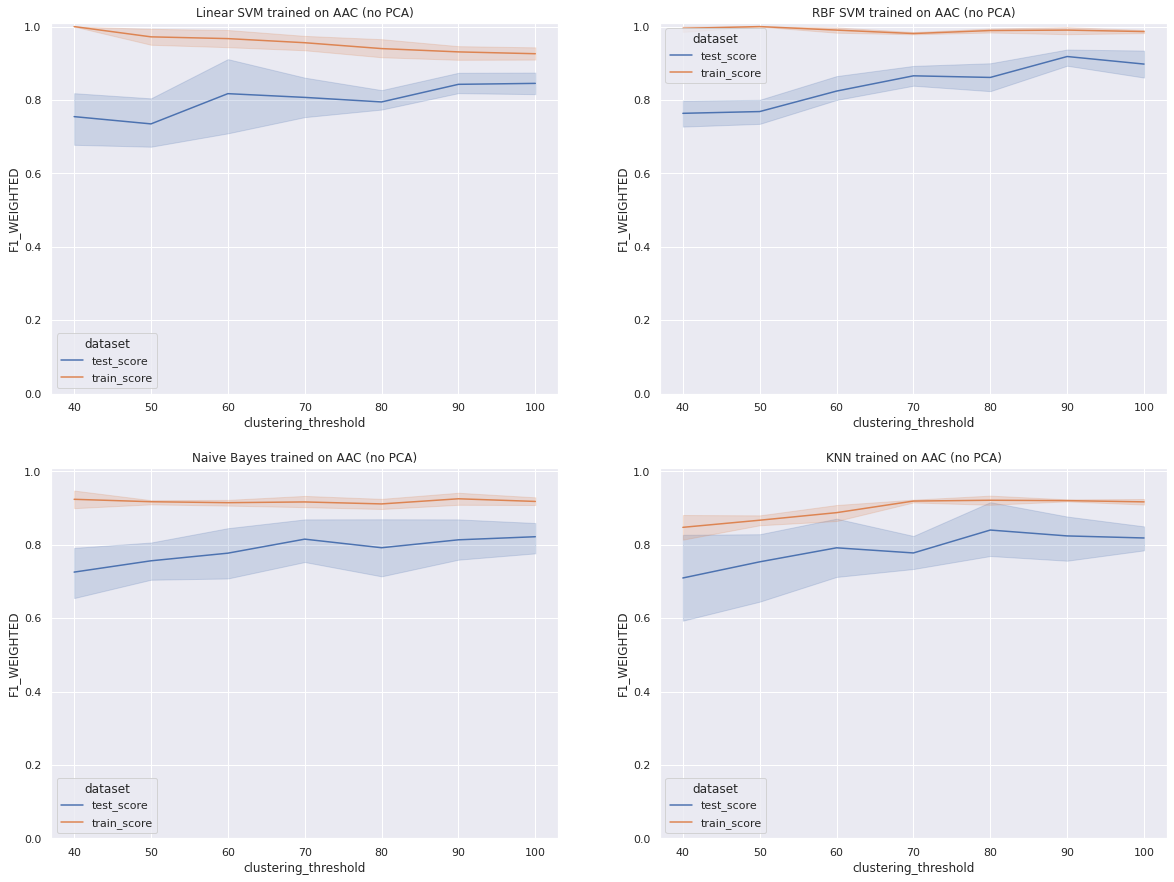

In [12]:
sns.set(rc={"figure.figsize": (20, 15)})
fig, axes = plt.subplots(2, 2)
classifier_clustering_plot(
    title="Linear SVM trained on AAC (no PCA)",
    dataset_name="athaliana_amino_sugar",
    feature_name="aac",
    pipe=make_pipeline(
        StandardScaler(),
        LinearSVC(class_weight="balanced", max_iter=1e6, random_state=0),
    ),
    params={},
    ax=axes[0, 0],
)
classifier_clustering_plot(
    title="RBF SVM trained on AAC (no PCA)",
    dataset_name="athaliana_amino_sugar",
    feature_name="aac",
    pipe=make_pipeline(
        StandardScaler(),
        SVC(class_weight="balanced", kernel="rbf"),
    ),
    params={},
    ax=axes[0, 1],
)
classifier_clustering_plot(
    title="Naive Bayes trained on AAC (no PCA)",
    dataset_name="athaliana_amino_sugar",
    feature_name="aac",
    pipe=make_pipeline(
        StandardScaler(),
        GaussianNB(),
    ),
    params={},
    ax=axes[1, 0],
)
classifier_clustering_plot(
    title="KNN trained on AAC (no PCA)",
    dataset_name="athaliana_amino_sugar",
    feature_name="aac",
    pipe=make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(),
    ),
    params={},
    ax=axes[1, 1],
)
